In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from Energy.Models.baseline import baseline
from HelpFunctions.calc_score import evaluate_horizon
from HelpFunctions.mix_models import mix_models
from Energy.Models.Model1 import model1
from Energy.Models.Model2 import model2

# import importlib
# importlib.reload(Energy.Models)

If needed: Fetch energy-data first

In [ ]:
# from Energy.HelpFunctions.get_energy_data import fetch_energy_data
# fetch_energy_data()

In [ ]:
df = get_energy_data()
df = prepare_data(df)

# Cross validate baseline model

Remove everything til last thursday night 12pm

In [ ]:
start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

Repeatedly run the model. Record predictions and true values (observations). Make sure the observations are available for the most recent prediction.

In [ ]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)        
        
        pred = None     
        # Is mixed model?
        if callable(model['function']):
            pred = model['function'](df_before)
        else: 
            pred = mix_models(model['function'][0], model['function'][1], df_before)
               
        
        obs = pd.DataFrame({'gesamt': df.loc[pred['forecast_date']]["gesamt"]})
        pred = pred.set_index('forecast_date')
        merged_df = pd.merge(pred, obs, left_index=True, right_index=True) 
    
    
         # Add scores to the merged_df
        for index, row in merged_df.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['gesamt']
            score = evaluate_horizon(quantile_preds, observation)
            merged_df.at[index, 'score'] = score
        # print(merged_df[['q0.025','q0.25','q0.5','q0.75','q0.975']])
        evaluation = pd.concat([evaluation, merged_df])
    return evaluation

## Evaluation of selected Models

In [ ]:
from Energy.Models.Model4 import model4
from Energy.Models.Model3 import model3

models = [
    # {
    #     'name': 'MM_baseline_model3',
    #     'function': [[baseline, model1],[0.5,0.5]]
    # },
    # {
    #     'name': 'baseline',
    #     'function': baseline
    #  },
    # {
    #     'name': 'model1',
    #     'function': model1
    # },
    # {
    #     'name': 'model2',
    #     'function': model2
    # },
    {
        'name': 'model3',
        'function': model3
    },
    {
        'name': 'model4',
        'function': model4
    },
    
]

start_date_excl = most_recent_thursday(df)
df_cval = df.loc[df.index < start_date_excl]

In [8]:
evaluate_models(models, df_cval, last_x=100, weeks=True)

Iteration 14 of 30
Iteration 15 of 30
Iteration 16 of 30
Iteration 17 of 30
Iteration 18 of 30
Iteration 19 of 30
Iteration 20 of 30
Iteration 21 of 30
Iteration 22 of 30
Iteration 23 of 30
Iteration 24 of 30
Iteration 25 of 30
Iteration 26 of 30
Iteration 27 of 30
Iteration 28 of 30
Iteration 29 of 30
*********** Start the evaluation of Model model4 ***********
Iteration 0 of 30
                     energy_consumption  winter  high_consumption_time  \
date_time                                                                
2018-12-24 00:00:00            42.02925       1                      0   
2018-12-24 01:00:00            39.61025       1                      0   
2018-12-24 02:00:00            39.13875       1                      0   
2018-12-24 03:00:00            39.42100       1                      0   
2018-12-24 04:00:00            40.74775       1                      0   
...                                 ...     ...                    ...   
2023-11-15 19:00:00      

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


Iteration 4 of 30
                     energy_consumption  winter  high_consumption_time  \
date_time                                                                
2018-12-24 00:00:00            42.02925       1                      0   
2018-12-24 01:00:00            39.61025       1                      0   
2018-12-24 02:00:00            39.13875       1                      0   
2018-12-24 03:00:00            39.42100       1                      0   
2018-12-24 04:00:00            40.74775       1                      0   
...                                 ...     ...                    ...   
2023-10-18 19:00:00            65.51150       1                      1   
2023-10-18 20:00:00            62.15775       1                      0   
2023-10-18 21:00:00            58.54350       1                      0   
2023-10-18 22:00:00            55.22775       1                      0   
2023-10-18 23:00:00            51.44650       1                      0   

                   

### Save evaluations in pkl file

In [ ]:
with open('./Model evaluations/bl_m3_MM-bl-m3.pkl', 'wb') as f:
    pickle.dump(models, f)

# with open('model_evaluations.pkl', 'rb') as f:
#     models = pickle.load(f)

### Create a table that only contains the different scores of the different models

In [ ]:
# scores = [m['evaluation']['score'][m['evaluation']['horizon'] == '36 hour'] for m in models]
# horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
# 
# 
# names = [m['name'] for m in models]
# score_df = pd.concat(scores, axis=1,keys=names)

In [9]:
horizons = ['36 hour', '40 hour', '44 hour', '60 hour', '64 hour', '68 hour']
scores = []
names = []
for h in horizons:
    for m in models:
        col_name = f'{m["name"]}: {h}'
        scores.append(m['evaluation']['score'][m['evaluation']['horizon'] == h])
        names.append(col_name)

score_df = pd.concat(scores, axis=1,keys=names)

        

In [10]:
score_df

,model3: 36 hour,model4: 36 hour,model3: 40 hour,model4: 40 hour,model3: 44 hour,model4: 44 hour,model3: 60 hour,model4: 60 hour,model3: 64 hour,model4: 64 hour,model3: 68 hour,model4: 68 hour
forecast_date,,,,,,,,,,,,
2023-04-28 12:00:00,3.468711,5.087494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28 16:00:00,NaN,NaN,16.770496,11.835707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-28 20:00:00,NaN,NaN,NaN,NaN,4.496735,4.456042,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,4.510914,5.195155,NaN,NaN,NaN,NaN
2023-04-29 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.701662,8.543451,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 16:00:00,NaN,NaN,11.786313,6.527298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-17 20:00:00,NaN,NaN,NaN,NaN,5.945220,5.174812,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-18 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,6.512190,5.448971,NaN,NaN,NaN,NaN


### Plot the densities of the obtained scores

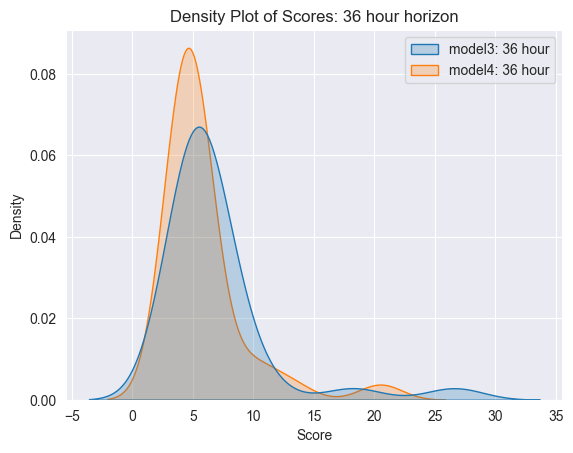

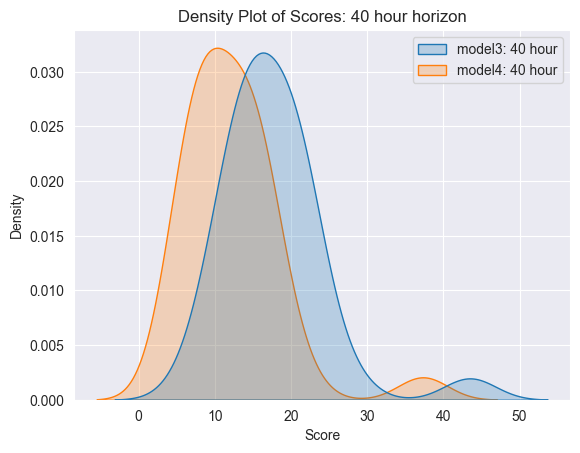

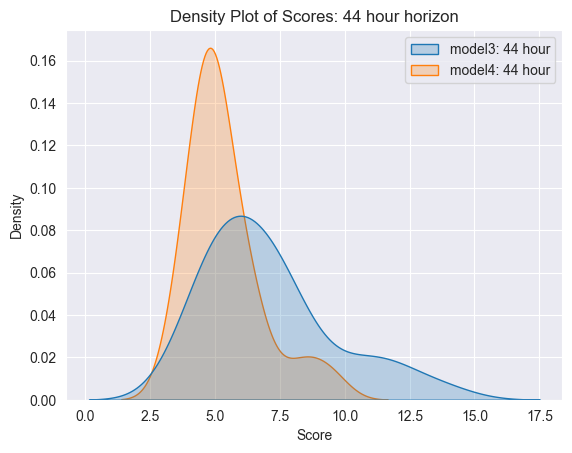

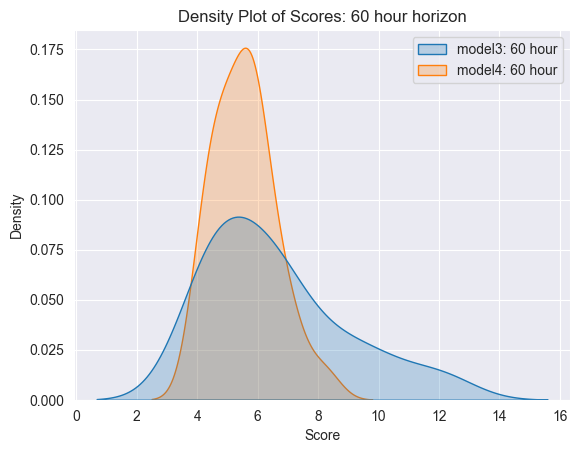

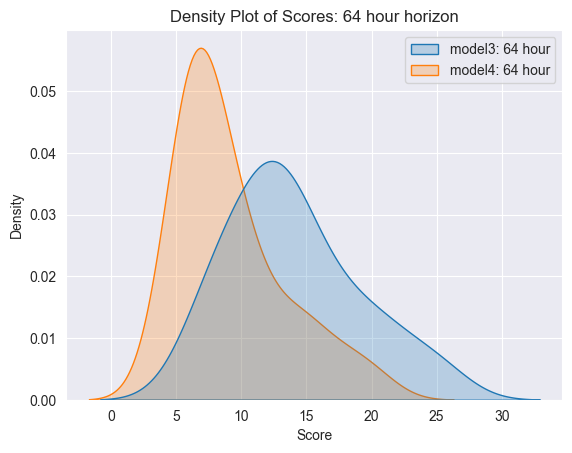

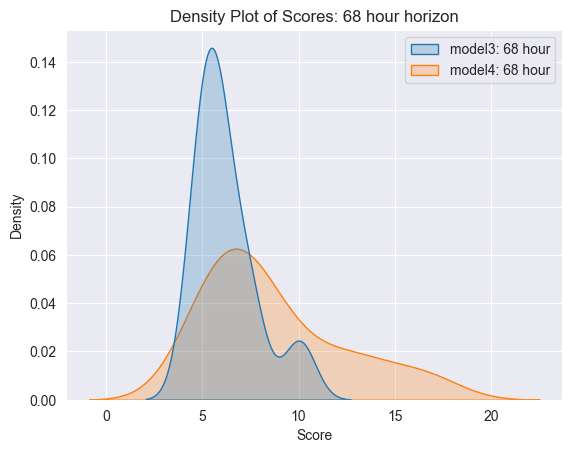

In [11]:
for h in [str(h) + " hour" for h in [36, 40, 44, 60, 64, 68]]:
    # sns.kdeplot(data=score_df.loc[:,[f'baseline: {h}',f'model3: {h}',f'MM_baseline_model3: {h}']], fill=True)
    sns.kdeplot(data=score_df.loc[:,[f'model3: {h}',f'model4: {h}']], fill=True)
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {h} horizon')
    
    # Display the plot
    plt.show()

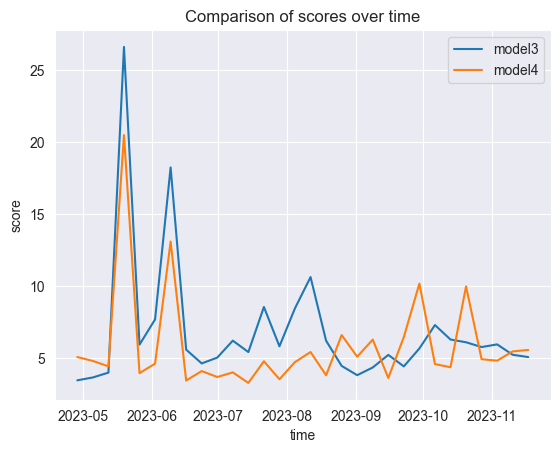

In [12]:
# Plot values from two columns over time
score_df_36_no_na = score_df[score_df['model3: 36 hour'].notna()]
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['model1: 36 hour'], label='model1')
# plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
plt.plot(score_df_36_no_na.index, score_df_36_no_na['model3: 36 hour'], label='model3')
plt.plot(score_df_36_no_na.index, score_df_36_no_na['model4: 36 hour'], label='model4')


# Adding labels and title
plt.xlabel('time')
plt.ylabel('score')
plt.title('Comparison of scores over time')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# mix_models([baseline2, model3], [1,1],df_cval)

In [ ]:
# # from HelpFunctions.mix_models import mix_models as mm
# # 
# # import importlib
# # importlib.reload(Energy.Models)
# 
# 
# from importlib import reload
# from HelpFunctions import mix_models as mms
# reload(mms)
# 
# mms.mix_models_per_horizon([baseline, model3, baseline], [[ 1,1,0,0,0,0], [0,0,1,1,0,0], [0,0,0,0,1,1]], df)